## Модели регрессии для российских квартир

Этот датасет предоставляет исчерпывающую информацию об объёмах продажах домов в России в период с 2018-2021 г.

В настоящее время найти квартиру себе по душе с идеальным расположением, площадью и инфраструктурой – одна из самых сложных и в то же время актуальных задач. Нужно обратить внимание на множество факторов – из каких материалов и как давно построен дом, в каком он состоянии, сколько в нем этажей, его расположение и, конечно, его стоимость.

#### Набор данных состоит из 13 полей:

- date - дата публикации объявления;

- time – время публикации;

- geo_lon - широта

- geo_lat - долгота

- region - регион

- building_type - 0 - Другой. 1 - Панельный. 2 - Монолитный. 3 - Кирпичный. 4 - Блочный. 5 - Деревянный

- object_type - Тип квартиры. 1 - Вторичный рынок недвижимости; 2 - Новостройка;

- level - этаж квартиры

- levels - количество этажей в доме

- rooms - количество жилых комнат. Если значение равно "-1", то это означает "однокомнатная квартира"

- area - общая площадь квартиры

- kitchen_area - площадь кухни

- price - цена в рублях

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
df = pd.read_csv('all_v2.csv')

In [7]:
df.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


Пропущенные значения в данных отсутствуют.

 # 1) Преобработка данных

Следующим шагом удалим из имеющейся таблицы записи, в которых цена отрицательна. Также ограничим значения таких величин, как area – от 20 до 200 кв.м., kitchen – от 6 до 30 кв.м., и установим пределы для стоимости жилья – от 1,5 до 50 млн.руб

In [12]:
MIN_AREA = 20  # Диапазон выбросов для площади пола
MAX_AREA = 200

MIN_KITCHEN = 6  # Диапазон выбросов для площади кухни
MAX_KITCHEN = 30

MIN_PRICE = 1_500_000  # Диапазон выбросов для цены на квартиру
MAX_PRICE = 50_000_000

In [13]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Функция удаляет ненужные данные, обрабатывает выбросы."""
    df.drop('time', axis=1, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    
    #  Колонка фактически содержит значения -1 и -2, предположительно для однокомнатных квартир.
    df['rooms'] = df['rooms'].apply(lambda x: 0 if x < 0 else x)
    df['price'] = df['price'].abs()  # Убираем отрицательные значения
    
    # Убираем выбросы в цене и площади
    df = df[(df['area'] <= MAX_AREA) & (df['area'] >= MIN_AREA)]
    df = df[(df['price'] <= MAX_PRICE) & (df['price'] >= MIN_PRICE)]
    
    # Убираем выбросы в колонке с площадью кухни
    # Но перед этим все "странные" значения мы заменим нулями
    df.loc[(df['kitchen_area'] >= MAX_KITCHEN) | (df['area'] <= MIN_AREA), 'kitchen_area'] = 0

    # Рассчитаем площадь кухни на основе площади пола, но только не для однокомнатных квартир
    erea_mean, kitchen_mean = df[['area', 'kitchen_area']].quantile(0.5)
    kitchen_share = kitchen_mean / erea_mean
    df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'kitchen_area'] = \
        df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'area'] * kitchen_share

    return df

In [14]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # Заменим "дату" числовыми характеристиками для года и месяца.
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df.drop('date', axis=1, inplace=True)
    # Этаж квартиры по отношению к общему количеству этажей.
    df['level_to_levels'] = df['level'] / df['levels']
    # Средняя площадь комнаты в квартире.
    df['area_to_rooms'] = (df['area'] / df['rooms']).abs()
    df.loc[df['area_to_rooms'] == np.inf, 'area_to_rooms'] = \
        df.loc[df['area_to_rooms'] == np.inf, 'area']
    return df

In [15]:
df = df.pipe(clean_data)
df = df.pipe(add_features)

In [16]:
df.head()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
0,6050000,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,2018,2,0.800000,27.533333
1,8650000,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,2018,2,0.208333,34.550000
2,4000000,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,2018,2,0.555556,22.000000
3,1850000,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,2018,3,0.750000,19.000000
4,5450000,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,2018,3,0.928571,30.000000


In [17]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [18]:
df.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
count,"4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00","4,747,486.00"
mean,"4,575,481.76",54.06,51.90,"4,083.81",1.95,6.51,11.95,1.87,55.51,10.80,3.93,"2,019.42",6.62,0.56,31.54
std,"4,115,397.60",4.68,20.44,"3,247.22",1.03,5.09,6.62,0.93,21.51,4.52,4.55,0.88,3.54,0.29,9.62
min,"1,500,000.00",41.46,19.89,3.00,0.00,1.00,1.00,0.00,20.00,0.00,1.00,"2,018.00",1.00,0.03,2.40
25%,"2,300,000.00",53.37,37.69,"2,661.00",1.00,3.00,6.00,1.00,40.00,8.00,1.00,"2,019.00",3.00,0.33,24.37
50%,"3,300,000.00",55.42,39.86,"2,900.00",2.00,5.00,10.00,2.00,51.50,10.00,1.00,"2,019.00",7.00,0.57,30.00
75%,"5,200,000.00",56.30,65.48,"6,171.00",3.00,9.00,17.00,3.00,65.00,13.00,11.00,"2,020.00",10.00,0.80,37.00
max,"50,000,000.00",71.98,162.54,"61,888.00",5.00,39.00,39.00,9.00,200.00,38.83,11.00,"2,021.00",12.00,17.00,200.00


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4747486 entries, 0 to 5477005
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   price            int64  
 1   geo_lat          float64
 2   geo_lon          float64
 3   region           int64  
 4   building_type    int64  
 5   level            int64  
 6   levels           int64  
 7   rooms            int64  
 8   area             float64
 9   kitchen_area     float64
 10  object_type      int64  
 11  year             int32  
 12  month            int32  
 13  level_to_levels  float64
 14  area_to_rooms    float64
dtypes: float64(6), int32(2), int64(7)
memory usage: 543.3 MB


# 2) Визуализация

График распределения цены

Сильной зависимости не наблюдается ввиду того, что много признаков

Price range: 1500000 - 50000000
Mean price: 4575481
Median price: 3300000
Standard deviation: 4115397


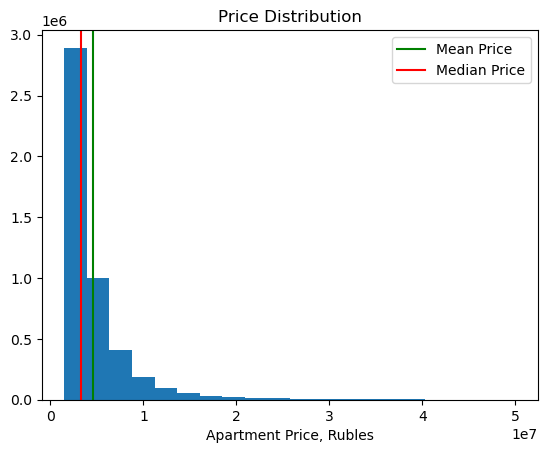

In [23]:
mean_price = int(df['price'].mean())
median_price = int(df['price'].median())

std = int(df['price'].std())

min_price = int(df['price'].min())
max_price = int(df['price'].max())

print(f'Price range: {min_price} - {max_price}')
print(f'Mean price: {mean_price}\nMedian price: {median_price}')
print(f'Standard deviation: {std}')

plt.hist(df['price'], bins=20)
plt.axvline(mean_price, label='Mean Price', color='green')
plt.axvline(median_price, label='Median Price', color='red')
plt.legend()
plt.xlabel('Apartment Price, Rubles')
plt.title('Price Distribution')
plt.show()

Средняя стоимость квартиры – 4,575,481 руб.

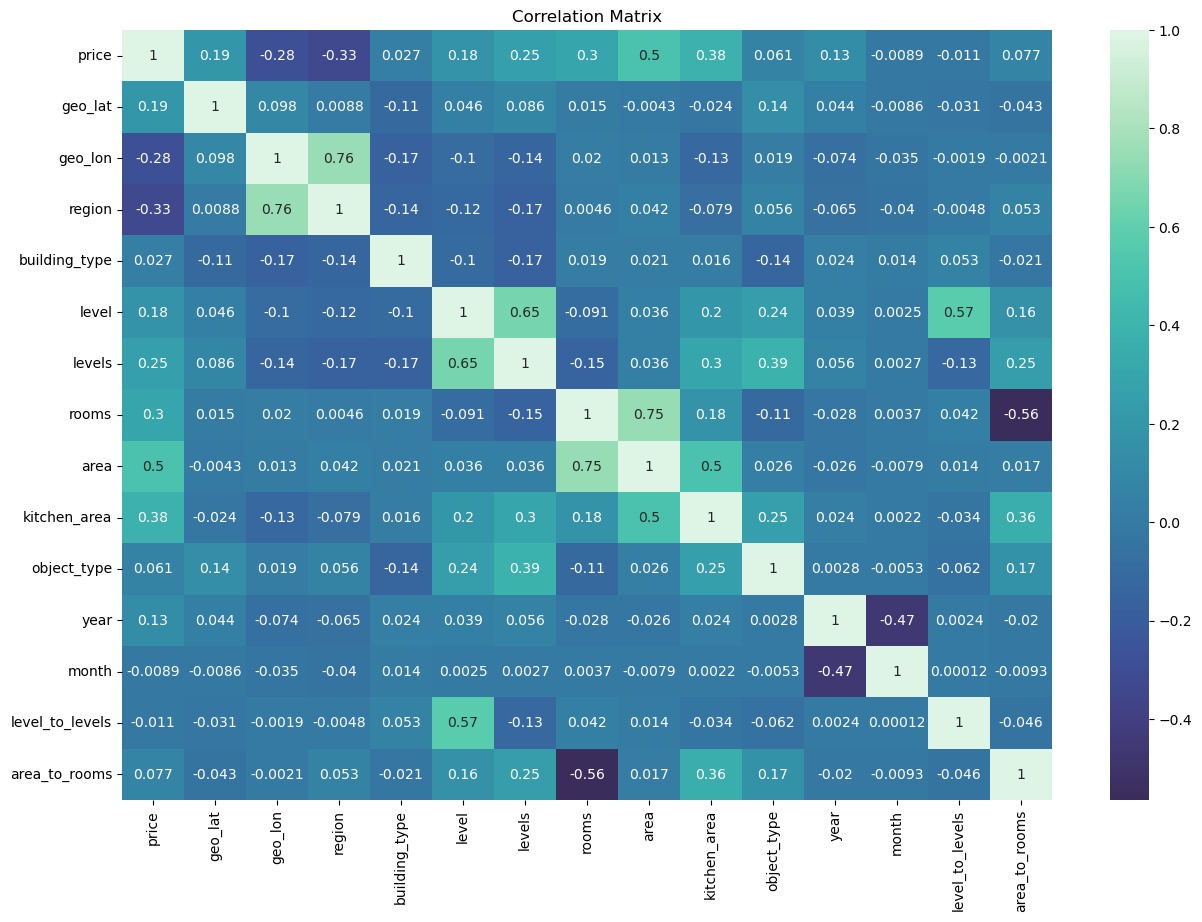

In [25]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), center=0, cmap='mako', annot=True)
plt.title('Correlation Matrix')
plt.show()

# Создание моделей

### Классическая модель

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

In [29]:
X, y = df.drop('price', axis=1), df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

In [30]:
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 регуляризация
    reg_lambda=1,    # L2 регуляризация
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'  # Важно для регрессии!
)

In [31]:
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [32]:
y_pred = model.predict(X_test)

In [33]:
print("Результаты XGBoost регрессии:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

Результаты XGBoost регрессии:
MAE: 759026.44
MSE: 2231223451648.00
RMSE: 1493728.04
R²: 0.8681


#### XGBRegressor показала себя лучше, с результатом в 0.86
# Основные причины:
1. Табличные данные (структурированные) → XGBoost специализирован на них
2. Большой датасет (а так бы набрала болье)
3. XGBoost лучше обрабатывает нелинейные зависимости в таблицах

## Нейронная модель

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
y_train_log = np.log1p(y_train) 
y_test_log = np.log1p(y_test)

In [39]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [40]:
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [41]:
y_train_scaled = scaler_y.fit_transform(y_train_log.values.reshape(-1, 1)).flatten()

In [126]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [128]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 256)               3840      
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                      

In [130]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

In [132]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [134]:
sample_size = int(0.7 * len(X_train))
indices = np.random.choice(len(X_train), sample_size, replace=False)

X_train_small = X_train_scaled[indices]
y_train_small = y_train_scaled[indices]

In [136]:
history = model.fit(
    X_train_small,  
    y_train_small, 
    epochs=25,      
    batch_size=1024,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
2078/2078 [==============================] - 30s 14ms/step - loss: 0.2630 - mae: 0.3862 - val_loss: 0.2078 - val_mae: 0.3361
Epoch 2/25
2078/2078 [==============================] - 30s 14ms/step - loss: 0.1958 - mae: 0.3307 - val_loss: 0.1662 - val_mae: 0.3041
Epoch 3/25
2078/2078 [==============================] - 29s 14ms/step - loss: 0.1554 - mae: 0.2951 - val_loss: 0.1402 - val_mae: 0.2807
Epoch 4/25
2078/2078 [==============================] - 30s 14ms/step - loss: 0.1429 - mae: 0.2817 - val_loss: 0.1344 - val_mae: 0.2726
Epoch 5/25
2078/2078 [==============================] - 31s 15ms/step - loss: 0.1369 - mae: 0.2750 - val_loss: 0.1256 - val_mae: 0.2641
Epoch 6/25
2078/2078 [==============================] - 41s 20ms/step - loss: 0.1334 - mae: 0.2709 - val_loss: 0.1248 - val_mae: 0.2626
Epoch 7/25
2078/2078 [==============================] - 38s 18ms/step - loss: 0.1313 - mae: 0.2685 - val_loss: 0.1404 - val_mae: 0.2740
Epoch 8/25
2078/2078 [==========================

In [137]:
nn_predictions_scaled = model.predict(X_test_scaled)

In [138]:
nn_predictions_log = scaler_y.inverse_transform(nn_predictions_scaled).flatten()

In [139]:
nn_predictions = np.expm1(nn_predictions_log)

In [140]:
print("Результаты нейронной модели:")
print(f"MAE: {mean_absolute_error(y_test, nn_predictions):.2f}")
print(f"MSE: {mean_squared_error(y_test, nn_predictions):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, nn_predictions)):.2f}")
print(f"R²: {r2_score(y_test, nn_predictions):.4f}")

Результаты нейронной модели:
MAE: 753217.31
MSE: 2723729375232.00
RMSE: 1650372.50
R²: 0.8394


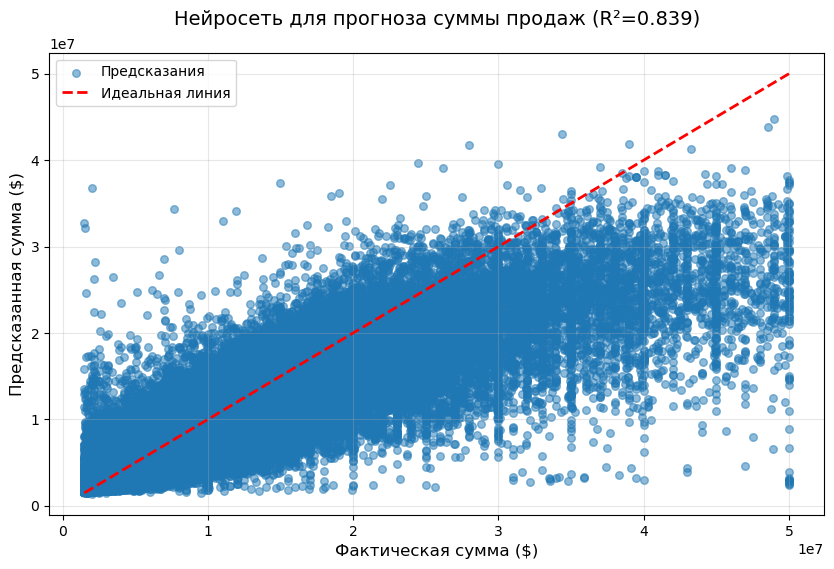

In [146]:
plt.figure(figsize=(10, 6))

# Фактические vs предсказанные значения
plt.scatter(y_test, nn_predictions, alpha=0.5, s=30, label='Предсказания')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Идеальная линия')

plt.xlabel('Фактическая сумма ($)', fontsize=12)
plt.ylabel('Предсказанная сумма ($)', fontsize=12)
plt.title(f'Нейросеть для прогноза суммы продаж (R²={r2_score(y_test, nn_predictions):.3f})', 
          fontsize=14, pad=20)
plt.legend()
plt.grid(True, alpha=0.3)

#### Нейросеть показала себя чуть хуже, с результатом в 0.83
# Основные причины:
1. Табличные данные (структурированные) → Нейросеть хуже специализирована на них
2. Хотя и большой датасет она справилась хуже, возможно потому что много эпох
3. Нейросеть хуже обрабатывает нелинейные зависимости в таблицах

### Общий вывод
В целом обе модели показала себя замечательно с результатом свыше 75 процентов, нейросеть к сожелению показала себя хуже, даже если добавить больше нейронов, была проблема в очень долгом обучении, тем более при большом количестве эпох, возмонжо если бы добавил большее количество эпох было бы лучше, но и нельзя забывать что текущая технология нейросети очень простая